<a href="https://colab.research.google.com/github/s-mostafa-a/lung-cancer-segmentation/blob/master/3d_lung_seg_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! git clone https://github.com/circulosmeos/gdown.pl

Cloning into 'gdown.pl'...
remote: Enumerating objects: 92, done.
remote: Total 92 (delta 0), reused 0 (delta 0), pack-reused 92
Unpacking objects: 100% (92/92), done.


In [2]:
!./gdown.pl/gdown.pl https://drive.google.com/file/d/1s3X1zJMGIQVN5V9zD8hcKLlnIz96pH-W

Cannot open cookies file ‘gdown.cookie.temp’: No such file or directory
--2020-07-05 11:18:27--  https://docs.google.com/uc?id=1s3X1zJMGIQVN5V9zD8hcKLlnIz96pH-W&export=download
Resolving docs.google.com (docs.google.com)... 173.194.197.102, 173.194.197.100, 173.194.197.139, ...
Connecting to docs.google.com (docs.google.com)|173.194.197.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘gdown.20200705111827.412387464269163’

     0K                                     36.8M=0s

2020-07-05 11:18:27 (36.8 MB/s) - ‘gdown.20200705111827.412387464269163’ saved [3259]

--2020-07-05 11:18:27--  https://docs.google.com/uc?export=download&confirm=E_n2&id=1s3X1zJMGIQVN5V9zD8hcKLlnIz96pH-W
Resolving docs.google.com (docs.google.com)... 173.194.197.101, 173.194.197.113, 173.194.197.139, ...
Connecting to docs.google.com (docs.google.com)|173.194.197.101|:443... connected.
HTTP request sent, awaiting response... 302 Moved Temporarily
Lo

In [3]:
!mv gdown.20* lung.tar

In [4]:
!tar -xf lung.tar

In [5]:
!pip install git+git://github.com/s-mostafa-a/niftidataset.git

  Cloning git://github.com/s-mostafa-a/niftidataset.git to /tmp/pip-req-build-wtjrc71i
  Running command git clone -q git://github.com/s-mostafa-a/niftidataset.git /tmp/pip-req-build-wtjrc71i
  Created wheel for niftidataset: filename=niftidataset-0.2.0-cp36-none-any.whl size=11603 sha256=af57f027ef345be8410ae98e0f72593fd6a01670ef50b084a993e2f8af8f2451
  Stored in directory: /tmp/pip-ephem-wheel-cache-d6q1jho8/wheels/90/80/c0/09c0a7dbe8a2902eeca8ebc007b7cbe2b5a06389d3f71d54f9
Successfully built niftidataset


In [6]:
from niftidataset import *
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import fastai
from fastai import vision
import torch
from torch import nn
from torchvision import transforms 
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [7]:
train_dir = '/content/Task06_Lung/'
patch_sz = 64
tfms = transforms.Compose([RandomCrop3D(patch_sz), ToTensor()])
dataset = NiftiTrainValidation(source_dir=train_dir+'imagesTr', target_dir=train_dir+'labelsTr', valid_pct=0.2, transform=tfms)
tds = dataset.get_train()
vds = dataset.get_validation()
print(len(tds), len(vds))

51 12


In [8]:
from fastai import vision as faiv
idb = faiv.ImageDataBunch.create(tds, vds, bs=2, num_workers=1)

In [9]:
from functools import partial

import torch
from torch import nn as nn
from torch.nn import functional as F


def conv3d(in_channels, out_channels, kernel_size, bias, padding):
    return nn.Conv3d(in_channels, out_channels, kernel_size, padding=padding, bias=bias)


def create_conv(in_channels, out_channels, kernel_size, order, num_groups, padding):
    """
    Create a list of modules with together constitute a single conv layer with non-linearity
    and optional batchnorm/groupnorm.
    Args:
        in_channels (int): number of input channels
        out_channels (int): number of output channels
        kernel_size(int or tuple): size of the convolving kernel
        order (string): order of things, e.g.
            'cr' -> conv + ReLU
            'gcr' -> groupnorm + conv + ReLU
            'cl' -> conv + LeakyReLU
            'ce' -> conv + ELU
            'bcr' -> batchnorm + conv + ReLU
        num_groups (int): number of groups for the GroupNorm
        padding (int or tuple): add zero-padding added to all three sides of the input
    Return:
        list of tuple (name, module)
    """
    assert 'c' in order, "Conv layer MUST be present"
    assert order[0] not in 'rle', 'Non-linearity cannot be the first operation in the layer'

    modules = []
    for i, char in enumerate(order):
        if char == 'r':
            modules.append(('ReLU', nn.ReLU(inplace=True)))
        elif char == 'l':
            modules.append(('LeakyReLU', nn.LeakyReLU(negative_slope=0.1, inplace=True)))
        elif char == 'e':
            modules.append(('ELU', nn.ELU(inplace=True)))
        elif char == 'c':
            # add learnable bias only in the absence of batchnorm/groupnorm
            bias = not ('g' in order or 'b' in order)
            modules.append(('conv', conv3d(in_channels, out_channels, kernel_size, bias, padding=padding)))
        elif char == 'g':
            is_before_conv = i < order.index('c')
            if is_before_conv:
                num_channels = in_channels
            else:
                num_channels = out_channels

            # use only one group if the given number of groups is greater than the number of channels
            if num_channels < num_groups:
                num_groups = 1

            assert num_channels % num_groups == 0, f'Expected number of channels in input to be divisible by num_groups. num_channels={num_channels}, num_groups={num_groups}'
            modules.append(('groupnorm', nn.GroupNorm(num_groups=num_groups, num_channels=num_channels)))
        elif char == 'b':
            is_before_conv = i < order.index('c')
            if is_before_conv:
                modules.append(('batchnorm', nn.BatchNorm3d(in_channels)))
            else:
                modules.append(('batchnorm', nn.BatchNorm3d(out_channels)))
        else:
            raise ValueError(f"Unsupported layer type '{char}'. MUST be one of ['b', 'g', 'r', 'l', 'e', 'c']")

    return modules


class SingleConv(nn.Sequential):
    """
    Basic convolutional module consisting of a Conv3d, non-linearity and optional batchnorm/groupnorm. The order
    of operations can be specified via the `order` parameter
    Args:
        in_channels (int): number of input channels
        out_channels (int): number of output channels
        kernel_size (int or tuple): size of the convolving kernel
        order (string): determines the order of layers, e.g.
            'cr' -> conv + ReLU
            'crg' -> conv + ReLU + groupnorm
            'cl' -> conv + LeakyReLU
            'ce' -> conv + ELU
        num_groups (int): number of groups for the GroupNorm
        padding (int or tuple):
    """

    def __init__(self, in_channels, out_channels, kernel_size=3, order='gcr', num_groups=8, padding=1):
        super(SingleConv, self).__init__()

        for name, module in create_conv(in_channels, out_channels, kernel_size, order, num_groups, padding=padding):
            self.add_module(name, module)


class DoubleConv(nn.Sequential):
    """
    A module consisting of two consecutive convolution layers (e.g. BatchNorm3d+ReLU+Conv3d).
    We use (Conv3d+ReLU+GroupNorm3d) by default.
    This can be changed however by providing the 'order' argument, e.g. in order
    to change to Conv3d+BatchNorm3d+ELU use order='cbe'.
    Use padded convolutions to make sure that the output (H_out, W_out) is the same
    as (H_in, W_in), so that you don't have to crop in the decoder path.
    Args:
        in_channels (int): number of input channels
        out_channels (int): number of output channels
        encoder (bool): if True we're in the encoder path, otherwise we're in the decoder
        kernel_size (int or tuple): size of the convolving kernel
        order (string): determines the order of layers, e.g.
            'cr' -> conv + ReLU
            'crg' -> conv + ReLU + groupnorm
            'cl' -> conv + LeakyReLU
            'ce' -> conv + ELU
        num_groups (int): number of groups for the GroupNorm
        padding (int or tuple): add zero-padding added to all three sides of the input
    """

    def __init__(self, in_channels, out_channels, encoder, kernel_size=3, order='gcr', num_groups=8, padding=1):
        super(DoubleConv, self).__init__()
        if encoder:
            # we're in the encoder path
            conv1_in_channels = in_channels
            conv1_out_channels = out_channels // 2
            if conv1_out_channels < in_channels:
                conv1_out_channels = in_channels
            conv2_in_channels, conv2_out_channels = conv1_out_channels, out_channels
        else:
            # we're in the decoder path, decrease the number of channels in the 1st convolution
            conv1_in_channels, conv1_out_channels = in_channels, out_channels
            conv2_in_channels, conv2_out_channels = out_channels, out_channels

        # conv1
        self.add_module('SingleConv1',
                        SingleConv(conv1_in_channels, conv1_out_channels, kernel_size, order, num_groups,
                                   padding=padding))
        # conv2
        self.add_module('SingleConv2',
                        SingleConv(conv2_in_channels, conv2_out_channels, kernel_size, order, num_groups,
                                   padding=padding))


class ExtResNetBlock(nn.Module):
    """
    Basic UNet block consisting of a SingleConv followed by the residual block.
    The SingleConv takes care of increasing/decreasing the number of channels and also ensures that the number
    of output channels is compatible with the residual block that follows.
    This block can be used instead of standard DoubleConv in the Encoder module.
    Motivated by: https://arxiv.org/pdf/1706.00120.pdf
    Notice we use ELU instead of ReLU (order='cge') and put non-linearity after the groupnorm.
    """

    def __init__(self, in_channels, out_channels, kernel_size=3, order='cge', num_groups=8, **kwargs):
        super(ExtResNetBlock, self).__init__()

        # first convolution
        self.conv1 = SingleConv(in_channels, out_channels, kernel_size=kernel_size, order=order, num_groups=num_groups)
        # residual block
        self.conv2 = SingleConv(out_channels, out_channels, kernel_size=kernel_size, order=order, num_groups=num_groups)
        # remove non-linearity from the 3rd convolution since it's going to be applied after adding the residual
        n_order = order
        for c in 'rel':
            n_order = n_order.replace(c, '')
        self.conv3 = SingleConv(out_channels, out_channels, kernel_size=kernel_size, order=n_order,
                                num_groups=num_groups)

        # create non-linearity separately
        if 'l' in order:
            self.non_linearity = nn.LeakyReLU(negative_slope=0.1, inplace=True)
        elif 'e' in order:
            self.non_linearity = nn.ELU(inplace=True)
        else:
            self.non_linearity = nn.ReLU(inplace=True)

    def forward(self, x):
        # apply first convolution and save the output as a residual
        out = self.conv1(x)
        residual = out

        # residual block
        out = self.conv2(out)
        out = self.conv3(out)

        out += residual
        out = self.non_linearity(out)

        return out


class Encoder(nn.Module):
    """
    A single module from the encoder path consisting of the optional max
    pooling layer (one may specify the MaxPool kernel_size to be different
    than the standard (2,2,2), e.g. if the volumetric data is anisotropic
    (make sure to use complementary scale_factor in the decoder path) followed by
    a DoubleConv module.
    Args:
        in_channels (int): number of input channels
        out_channels (int): number of output channels
        conv_kernel_size (int or tuple): size of the convolving kernel
        apply_pooling (bool): if True use MaxPool3d before DoubleConv
        pool_kernel_size (int or tuple): the size of the window
        pool_type (str): pooling layer: 'max' or 'avg'
        basic_module(nn.Module): either ResNetBlock or DoubleConv
        conv_layer_order (string): determines the order of layers
            in `DoubleConv` module. See `DoubleConv` for more info.
        num_groups (int): number of groups for the GroupNorm
        padding (int or tuple): add zero-padding added to all three sides of the input
    """

    def __init__(self, in_channels, out_channels, conv_kernel_size=3, apply_pooling=True,
                 pool_kernel_size=2, pool_type='max', basic_module=DoubleConv, conv_layer_order='gcr',
                 num_groups=8, padding=1):
        super(Encoder, self).__init__()
        assert pool_type in ['max', 'avg']
        if apply_pooling:
            if pool_type == 'max':
                self.pooling = nn.MaxPool3d(kernel_size=pool_kernel_size)
            else:
                self.pooling = nn.AvgPool3d(kernel_size=pool_kernel_size)
        else:
            self.pooling = None

        self.basic_module = basic_module(in_channels, out_channels,
                                         encoder=True,
                                         kernel_size=conv_kernel_size,
                                         order=conv_layer_order,
                                         num_groups=num_groups,
                                         padding=padding)

    def forward(self, x):
        if self.pooling is not None:
            x = self.pooling(x)
        x = self.basic_module(x)
        return x


class Decoder(nn.Module):
    """
    A single module for decoder path consisting of the upsampling layer
    (either learned ConvTranspose3d or nearest neighbor interpolation) followed by a basic module (DoubleConv or ExtResNetBlock).
    Args:
        in_channels (int): number of input channels
        out_channels (int): number of output channels
        conv_kernel_size (int or tuple): size of the convolving kernel
        scale_factor (tuple): used as the multiplier for the image H/W/D in
            case of nn.Upsample or as stride in case of ConvTranspose3d, must reverse the MaxPool3d operation
            from the corresponding encoder
        basic_module(nn.Module): either ResNetBlock or DoubleConv
        conv_layer_order (string): determines the order of layers
            in `DoubleConv` module. See `DoubleConv` for more info.
        num_groups (int): number of groups for the GroupNorm
        padding (int or tuple): add zero-padding added to all three sides of the input
    """

    def __init__(self, in_channels, out_channels, conv_kernel_size=3, scale_factor=(2, 2, 2), basic_module=DoubleConv,
                 conv_layer_order='gcr', num_groups=8, mode='nearest', padding=1):
        super(Decoder, self).__init__()
        if basic_module == DoubleConv:
            # if DoubleConv is the basic_module use interpolation for upsampling and concatenation joining
            self.upsampling = Upsampling(transposed_conv=False, in_channels=in_channels, out_channels=out_channels,
                                         kernel_size=conv_kernel_size, scale_factor=scale_factor, mode=mode)
            # concat joining
            self.joining = partial(self._joining, concat=True)
        else:
            # if basic_module=ExtResNetBlock use transposed convolution upsampling and summation joining
            self.upsampling = Upsampling(transposed_conv=True, in_channels=in_channels, out_channels=out_channels,
                                         kernel_size=conv_kernel_size, scale_factor=scale_factor, mode=mode)
            # sum joining
            self.joining = partial(self._joining, concat=False)
            # adapt the number of in_channels for the ExtResNetBlock
            in_channels = out_channels

        self.basic_module = basic_module(in_channels, out_channels,
                                         encoder=False,
                                         kernel_size=conv_kernel_size,
                                         order=conv_layer_order,
                                         num_groups=num_groups,
                                         padding=padding)

    def forward(self, encoder_features, x):
        x = self.upsampling(encoder_features=encoder_features, x=x)
        x = self.joining(encoder_features, x)
        x = self.basic_module(x)
        return x

    @staticmethod
    def _joining(encoder_features, x, concat):
        if concat:
            return torch.cat((encoder_features, x), dim=1)
        else:
            return encoder_features + x


class Upsampling(nn.Module):
    """
    Upsamples a given multi-channel 3D data using either interpolation or learned transposed convolution.
    Args:
        transposed_conv (bool): if True uses ConvTranspose3d for upsampling, otherwise uses interpolation
        in_channels (int): number of input channels for transposed conv
            used only if transposed_conv is True
        out_channels (int): number of output channels for transpose conv
            used only if transposed_conv is True
        kernel_size (int or tuple): size of the convolving kernel
            used only if transposed_conv is True
        scale_factor (int or tuple): stride of the convolution
            used only if transposed_conv is True
        mode (str): algorithm used for upsampling:
            'nearest' | 'linear' | 'bilinear' | 'trilinear' | 'area'. Default: 'nearest'
            used only if transposed_conv is False
    """

    def __init__(self, transposed_conv, in_channels=None, out_channels=None, kernel_size=3,
                 scale_factor=(2, 2, 2), mode='nearest'):
        super(Upsampling, self).__init__()

        if transposed_conv:
            # make sure that the output size reverses the MaxPool3d from the corresponding encoder
            # (D_out = (D_in − 1) ×  stride[0] − 2 ×  padding[0] +  kernel_size[0] +  output_padding[0])
            self.upsample = nn.ConvTranspose3d(in_channels, out_channels, kernel_size=kernel_size, stride=scale_factor,
                                               padding=1)
        else:
            self.upsample = partial(self._interpolate, mode=mode)

    def forward(self, encoder_features, x):
        output_size = encoder_features.size()[2:]
        return self.upsample(x, output_size)

    @staticmethod
    def _interpolate(x, size, mode):
        return F.interpolate(x, size=size, mode=mode)

In [10]:
import importlib

import torch.nn as nn

def number_of_features_per_level(init_channel_number, num_levels):
    return [init_channel_number * 2 ** k for k in range(num_levels)]


class Abstract3DUNet(nn.Module):
    """
    Base class for standard and residual UNet.
    Args:
        in_channels (int): number of input channels
        out_channels (int): number of output segmentation masks;
            Note that that the of out_channels might correspond to either
            different semantic classes or to different binary segmentation mask.
            It's up to the user of the class to interpret the out_channels and
            use the proper loss criterion during training (i.e. CrossEntropyLoss (multi-class)
            or BCEWithLogitsLoss (two-class) respectively)
        f_maps (int, tuple): number of feature maps at each level of the encoder; if it's an integer the number
            of feature maps is given by the geometric progression: f_maps ^ k, k=1,2,3,4
        final_sigmoid (bool): if True apply element-wise nn.Sigmoid after the
            final 1x1 convolution, otherwise apply nn.Softmax. MUST be True if nn.BCELoss (two-class) is used
            to train the model. MUST be False if nn.CrossEntropyLoss (multi-class) is used to train the model.
        basic_module: basic model for the encoder/decoder (DoubleConv, ExtResNetBlock, ....)
        layer_order (string): determines the order of layers
            in `SingleConv` module. e.g. 'crg' stands for Conv3d+ReLU+GroupNorm3d.
            See `SingleConv` for more info
        f_maps (int, tuple): if int: number of feature maps in the first conv layer of the encoder (default: 64);
            if tuple: number of feature maps at each level
        num_groups (int): number of groups for the GroupNorm
        num_levels (int): number of levels in the encoder/decoder path (applied only if f_maps is an int)
        is_segmentation (bool): if True (semantic segmentation problem) Sigmoid/Softmax normalization is applied
            after the final convolution; if False (regression problem) the normalization layer is skipped at the end
        testing (bool): if True (testing mode) the `final_activation` (if present, i.e. `is_segmentation=true`)
            will be applied as the last operation during the forward pass; if False the model is in training mode
            and the `final_activation` (even if present) won't be applied; default: False
        conv_kernel_size (int or tuple): size of the convolving kernel in the basic_module
        pool_kernel_size (int or tuple): the size of the window
        conv_padding (int or tuple): add zero-padding added to all three sides of the input
    """

    def __init__(self, in_channels, out_channels, final_sigmoid, basic_module, f_maps=64, layer_order='gcr',
                 num_groups=8, num_levels=4, is_segmentation=True, testing=False,
                 conv_kernel_size=3, pool_kernel_size=2, conv_padding=1, **kwargs):
        super(Abstract3DUNet, self).__init__()

        self.testing = testing

        if isinstance(f_maps, int):
            f_maps = number_of_features_per_level(f_maps, num_levels=num_levels)

        # create encoder path consisting of Encoder modules. Depth of the encoder is equal to `len(f_maps)`
        encoders = []
        for i, out_feature_num in enumerate(f_maps):
            if i == 0:
                encoder = Encoder(in_channels, out_feature_num,
                                  apply_pooling=False,  # skip pooling in the firs encoder
                                  basic_module=basic_module,
                                  conv_layer_order=layer_order,
                                  conv_kernel_size=conv_kernel_size,
                                  num_groups=num_groups,
                                  padding=conv_padding)
            else:
                # TODO: adapt for anisotropy in the data, i.e. use proper pooling kernel to make the data isotropic after 1-2 pooling operations
                encoder = Encoder(f_maps[i - 1], out_feature_num,
                                  basic_module=basic_module,
                                  conv_layer_order=layer_order,
                                  conv_kernel_size=conv_kernel_size,
                                  num_groups=num_groups,
                                  pool_kernel_size=pool_kernel_size,
                                  padding=conv_padding)

            encoders.append(encoder)

        self.encoders = nn.ModuleList(encoders)

        # create decoder path consisting of the Decoder modules. The length of the decoder is equal to `len(f_maps) - 1`
        decoders = []
        reversed_f_maps = list(reversed(f_maps))
        for i in range(len(reversed_f_maps) - 1):
            if basic_module == DoubleConv:
                in_feature_num = reversed_f_maps[i] + reversed_f_maps[i + 1]
            else:
                in_feature_num = reversed_f_maps[i]

            out_feature_num = reversed_f_maps[i + 1]
            # TODO: if non-standard pooling was used, make sure to use correct striding for transpose conv
            # currently strides with a constant stride: (2, 2, 2)
            decoder = Decoder(in_feature_num, out_feature_num,
                              basic_module=basic_module,
                              conv_layer_order=layer_order,
                              conv_kernel_size=conv_kernel_size,
                              num_groups=num_groups,
                              padding=conv_padding)
            decoders.append(decoder)

        self.decoders = nn.ModuleList(decoders)

        # in the last layer a 1×1 convolution reduces the number of output
        # channels to the number of labels
        self.final_conv = nn.Conv3d(f_maps[0], out_channels, 1)

        if is_segmentation:
            # semantic segmentation problem
            if final_sigmoid:
                self.final_activation = nn.Sigmoid()
            else:
                self.final_activation = nn.Softmax(dim=1)
        else:
            # regression problem
            self.final_activation = None

    def forward(self, x):
        # encoder part
        encoders_features = []
        for encoder in self.encoders:
            x = encoder(x)
            # reverse the encoder outputs to be aligned with the decoder
            encoders_features.insert(0, x)

        # remove the last encoder's output from the list
        # !!remember: it's the 1st in the list
        encoders_features = encoders_features[1:]

        # decoder part
        for decoder, encoder_features in zip(self.decoders, encoders_features):
            # pass the output from the corresponding encoder and the output
            # of the previous decoder
            x = decoder(encoder_features, x)

        x = self.final_conv(x)

        # apply final_activation (i.e. Sigmoid or Softmax) only during prediction. During training the network outputs
        # logits and it's up to the user to normalize it before visualising with tensorboard or computing validation metric
        if self.testing and self.final_activation is not None:
            x = self.final_activation(x)

        return x


class UNet3D(Abstract3DUNet):
    """
    3DUnet model from
    `"3D U-Net: Learning Dense Volumetric Segmentation from Sparse Annotation"
        <https://arxiv.org/pdf/1606.06650.pdf>`.
    Uses `DoubleConv` as a basic_module and nearest neighbor upsampling in the decoder
    """

    def __init__(self, in_channels, out_channels, final_sigmoid=True, f_maps=64, layer_order='gcr',
                 num_groups=8, num_levels=4, is_segmentation=True, conv_padding=1, **kwargs):
        super(UNet3D, self).__init__(in_channels=in_channels, out_channels=out_channels, final_sigmoid=final_sigmoid,
                                     basic_module=DoubleConv, f_maps=f_maps, layer_order=layer_order,
                                     num_groups=num_groups, num_levels=num_levels, is_segmentation=is_segmentation,
                                     conv_padding=conv_padding, **kwargs)


class ResidualUNet3D(Abstract3DUNet):
    """
    Residual 3DUnet model implementation based on https://arxiv.org/pdf/1706.00120.pdf.
    Uses ExtResNetBlock as a basic building block, summation joining instead
    of concatenation joining and transposed convolutions for upsampling (watch out for block artifacts).
    Since the model effectively becomes a residual net, in theory it allows for deeper UNet.
    """

    def __init__(self, in_channels, out_channels, final_sigmoid=True, f_maps=64, layer_order='gcr',
                 num_groups=8, num_levels=5, is_segmentation=True, conv_padding=1, **kwargs):
        super(ResidualUNet3D, self).__init__(in_channels=in_channels, out_channels=out_channels,
                                             final_sigmoid=final_sigmoid,
                                             basic_module=ExtResNetBlock, f_maps=f_maps, layer_order=layer_order,
                                             num_groups=num_groups, num_levels=num_levels,
                                             is_segmentation=is_segmentation, conv_padding=conv_padding,
                                             **kwargs)


class UNet2D(Abstract3DUNet):
    """
    Just a standard 2D Unet. Arises naturally by specifying conv_kernel_size=(1, 3, 3), pool_kernel_size=(1, 2, 2).
    """

    def __init__(self, in_channels, out_channels, final_sigmoid=True, f_maps=64, layer_order='gcr',
                 num_groups=8, num_levels=4, is_segmentation=True, conv_padding=1, **kwargs):
        if conv_padding == 1:
            conv_padding = (0, 1, 1)
        super(UNet2D, self).__init__(in_channels=in_channels,
                                     out_channels=out_channels,
                                     final_sigmoid=final_sigmoid,
                                     basic_module=DoubleConv,
                                     f_maps=f_maps,
                                     layer_order=layer_order,
                                     num_groups=num_groups,
                                     num_levels=num_levels,
                                     is_segmentation=is_segmentation,
                                     conv_kernel_size=(1, 3, 3),
                                     pool_kernel_size=(1, 2, 2),
                                     conv_padding=conv_padding,
                                     **kwargs)


In [11]:
def expand_as_one_hot(input, C, ignore_index=None):
    """
    Converts NxDxHxW label image to NxCxDxHxW, where each label gets converted to its corresponding one-hot vector
    :param input: 4D input image (NxDxHxW)
    :param C: number of channels/labels
    :param ignore_index: ignore index to be kept during the expansion
    :return: 5D output image (NxCxDxHxW)
    """
    assert input.dim() == 4

    # expand the input tensor to Nx1xDxHxW before scattering
    input = input.unsqueeze(1)
    # create result tensor shape (NxCxDxHxW)
    shape = list(input.size())
    shape[1] = C

    if ignore_index is not None:
        # create ignore_index mask for the result
        mask = input.expand(shape) == ignore_index
        # clone the src tensor and zero out ignore_index in the input
        input = input.clone()
        input[input == ignore_index] = 0
        # scatter to get the one-hot tensor
        result = torch.zeros(shape).to(input.device).scatter_(1, input, 1)
        # bring back the ignore_index in the result
        result[mask] = ignore_index
        return result
    else:
        # scatter to get the one-hot tensor
        return torch.zeros(shape).to(input.device).scatter_(1, input, 1)

In [12]:
## losses
import torch
from torch import nn

class ContrastiveLoss(nn.Module):
    """
    Implementation of contrastive loss defined in https://arxiv.org/pdf/1708.02551.pdf
    'Semantic Instance Segmentation with a Discriminative Loss Function'
    """

    def __init__(self, delta_var, delta_dist, norm='fro', alpha=1., beta=1., gamma=0.001):
        super(ContrastiveLoss, self).__init__()
        self.delta_var = delta_var
        self.delta_dist = delta_dist
        self.norm = norm
        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma

    def _compute_cluster_means(self, input, target):
        embedding_dims = input.size()[1]
        # expand target: NxCxDxHxW -> NxCxExDxHxW
        # NxCx1xDxHxW
        target = target.unsqueeze(2)
        # save target's copy in order to compute the average embeddings later
        target_copy = target.clone()
        shape = list(target.size())
        shape[2] = embedding_dims
        target = target.expand(shape)

        # expand input: NxExDxHxW -> Nx1xExDxHxW
        input = input.unsqueeze(1)

        # sum embeddings in each instance (multiply first via broadcasting) output: NxCxEx1x1x1
        embeddings_per_instance = input * target
        num = torch.sum(embeddings_per_instance, dim=(3, 4, 5), keepdim=True)
        # get number of voxels in each cluster output: NxCx1x1x1x1
        num_voxels_per_instance = torch.sum(target_copy, dim=(3, 4, 5), keepdim=True)
        # compute mean embeddings NxCxEx1x1x1
        mean_embeddings = num / num_voxels_per_instance
        # return mean embeddings and additional tensors needed for further computations
        return mean_embeddings, embeddings_per_instance

    def _compute_variance_term(self, cluster_means, embeddings_per_instance, target):
        # compute the distance to cluster means, result:(NxCxDxHxW)
        embedding_norms = torch.norm(embeddings_per_instance - cluster_means, self.norm, dim=2)
        # get per instance distances (apply instance mask)
        embedding_norms = embedding_norms * target
        # zero out distances less than delta_var and sum to get the variance (NxC)
        embedding_variance = torch.clamp(embedding_norms - self.delta_var, min=0) ** 2
        embedding_variance = torch.sum(embedding_variance, dim=(2, 3, 4))
        # get number of voxels per instance (NxC)
        num_voxels_per_instance = torch.sum(target, dim=(2, 3, 4))
        # normalize the variance term
        C = target.size()[1]
        variance_term = torch.sum(embedding_variance / num_voxels_per_instance, dim=1) / C
        return variance_term

    def _compute_distance_term(self, cluster_means, C):
        if C == 1:
            # just one cluster in the batch, so distance term does not contribute to the loss
            return 0.
        # squeeze space dims
        for _ in range(3):
            cluster_means = cluster_means.squeeze(-1)
        # expand cluster_means tensor in order to compute the pair-wise distance between cluster means
        cluster_means = cluster_means.unsqueeze(1)
        shape = list(cluster_means.size())
        shape[1] = C
        # NxCxCxEx1x1x1
        cm_matrix1 = cluster_means.expand(shape)
        # transpose the cluster_means matrix in order to compute pair-wise distances
        cm_matrix2 = cm_matrix1.permute(0, 2, 1, 3)
        # compute pair-wise distances (NxCxC)
        dist_matrix = torch.norm(cm_matrix1 - cm_matrix2, p=self.norm, dim=3)
        # create matrix for the repulsion distance (i.e. cluster centers further apart than 2 * delta_dist
        # are not longer repulsed)
        repulsion_dist = 2 * self.delta_dist * (1 - torch.eye(C))
        # 1xCxC
        repulsion_dist = repulsion_dist.unsqueeze(0).to(cluster_means.device)
        # zero out distances grater than 2*delta_dist (NxCxC)
        hinged_dist = torch.clamp(repulsion_dist - dist_matrix, min=0) ** 2
        # sum all of the hinged pair-wise distances
        hinged_dist = torch.sum(hinged_dist, dim=(1, 2))
        # normalized by the number of paris and return
        return hinged_dist / (C * (C - 1))

    def _compute_regularizer_term(self, cluster_means, C):
        # squeeze space dims
        for _ in range(3):
            cluster_means = cluster_means.squeeze(-1)
        norms = torch.norm(cluster_means, p=self.norm, dim=2)
        assert norms.size()[1] == C
        # return the average norm per batch
        return torch.sum(norms, dim=1).div(C)

    def forward(self, input, target):
        """
        Args:
             input (torch.tensor): embeddings predicted by the network (NxExDxHxW) (E - embedding dims)
             target (torch.tensor): ground truth instance segmentation (NxDxHxW)
        Returns:
            Combined loss defined as: alpha * variance_term + beta * distance_term + gamma * regularization_term
        """
        # get number of instances in the batch
        C = torch.unique(target).size()[0]
        # expand each label as a one-hot vector: N x D x H x W -> N x C x D x H x W
        target = expand_as_one_hot(target, C)
        # compare spatial dimensions
        assert input.dim() == target.dim() == 5
        assert input.size()[2:] == target.size()[2:]

        # compute mean embeddings and assign embeddings to instances
        cluster_means, embeddings_per_instance = self._compute_cluster_means(input, target)
        variance_term = self._compute_variance_term(cluster_means, embeddings_per_instance, target)
        distance_term = self._compute_distance_term(cluster_means, C)
        regularization_term = self._compute_regularizer_term(cluster_means, C)
        # total loss
        loss = self.alpha * variance_term + self.beta * distance_term + self.gamma * regularization_term
        # reduce batch dimension
        return torch.mean(loss)




import torch
import torch.nn.functional as F
from torch import nn as nn
from torch.autograd import Variable
from torch.nn import MSELoss, SmoothL1Loss, L1Loss


def compute_per_channel_dice(input, target, epsilon=1e-6, weight=None):
    """
    Computes DiceCoefficient as defined in https://arxiv.org/abs/1606.04797 given  a multi channel input and target.
    Assumes the input is a normalized probability, e.g. a result of Sigmoid or Softmax function.
    Args:
         input (torch.Tensor): NxCxSpatial input tensor
         target (torch.Tensor): NxCxSpatial target tensor
         epsilon (float): prevents division by zero
         weight (torch.Tensor): Cx1 tensor of weight per channel/class
    """

    # input and target shapes must match
    assert input.size() == target.size(), "'input' and 'target' must have the same shape"

    input = flatten(input)
    target = flatten(target)
    target = target.float()

    # compute per channel Dice Coefficient
    intersect = (input * target).sum(-1)
    if weight is not None:
        intersect = weight * intersect

    # here we can use standard dice (input + target).sum(-1) or extension (see V-Net) (input^2 + target^2).sum(-1)
    denominator = (input * input).sum(-1) + (target * target).sum(-1)
    return 2 * (intersect / denominator.clamp(min=epsilon))


class _MaskingLossWrapper(nn.Module):
    """
    Loss wrapper which prevents the gradient of the loss to be computed where target is equal to `ignore_index`.
    """

    def __init__(self, loss, ignore_index):
        super(_MaskingLossWrapper, self).__init__()
        assert ignore_index is not None, 'ignore_index cannot be None'
        self.loss = loss
        self.ignore_index = ignore_index

    def forward(self, input, target):
        mask = target.clone().ne_(self.ignore_index)
        mask.requires_grad = False

        # mask out input/target so that the gradient is zero where on the mask
        input = input * mask
        target = target * mask

        # forward masked input and target to the loss
        return self.loss(input, target)


class SkipLastTargetChannelWrapper(nn.Module):
    """
    Loss wrapper which removes additional target channel
    """

    def __init__(self, loss, squeeze_channel=False):
        super(SkipLastTargetChannelWrapper, self).__init__()
        self.loss = loss
        self.squeeze_channel = squeeze_channel

    def forward(self, input, target):
        assert target.size(1) > 1, 'Target tensor has a singleton channel dimension, cannot remove channel'

        # skips last target channel if needed
        target = target[:, :-1, ...]

        if self.squeeze_channel:
            # squeeze channel dimension if singleton
            target = torch.squeeze(target, dim=1)
        return self.loss(input, target)


class _AbstractDiceLoss(nn.Module):
    """
    Base class for different implementations of Dice loss.
    """

    def __init__(self, weight=None, sigmoid_normalization=True):
        super(_AbstractDiceLoss, self).__init__()
        self.register_buffer('weight', weight)
        # The output from the network during training is assumed to be un-normalized probabilities and we would
        # like to normalize the logits. Since Dice (or soft Dice in this case) is usually used for binary data,
        # normalizing the channels with Sigmoid is the default choice even for multi-class segmentation problems.
        # However if one would like to apply Softmax in order to get the proper probability distribution from the
        # output, just specify sigmoid_normalization=False.
        if sigmoid_normalization:
            self.normalization = nn.Sigmoid()
        else:
            self.normalization = nn.Softmax(dim=1)

    def dice(self, input, target, weight):
        # actual Dice score computation; to be implemented by the subclass
        raise NotImplementedError

    def forward(self, input, target):
        # get probabilities from logits
        input = self.normalization(input)

        # compute per channel Dice coefficient
        per_channel_dice = self.dice(input, target, weight=self.weight)

        # average Dice score across all channels/classes
        return 1. - torch.mean(per_channel_dice)


class DiceLoss(_AbstractDiceLoss):
    """Computes Dice Loss according to https://arxiv.org/abs/1606.04797.
    For multi-class segmentation `weight` parameter can be used to assign different weights per class.
    The input to the loss function is assumed to be a logit and will be normalized by the Sigmoid function.
    """

    def __init__(self, weight=None, sigmoid_normalization=True):
        super().__init__(weight, sigmoid_normalization)

    def dice(self, input, target, weight):
        return compute_per_channel_dice(input, target, weight=self.weight)


class GeneralizedDiceLoss(_AbstractDiceLoss):
    """Computes Generalized Dice Loss (GDL) as described in https://arxiv.org/pdf/1707.03237.pdf.
    """

    def __init__(self, sigmoid_normalization=True, epsilon=1e-6):
        super().__init__(weight=None, sigmoid_normalization=sigmoid_normalization)
        self.epsilon = epsilon

    def dice(self, input, target, weight):
        assert input.size() == target.size(), "'input' and 'target' must have the same shape"

        input = flatten(input)
        target = flatten(target)
        target = target.float()

        if input.size(0) == 1:
            # for GDL to make sense we need at least 2 channels (see https://arxiv.org/pdf/1707.03237.pdf)
            # put foreground and background voxels in separate channels
            input = torch.cat((input, 1 - input), dim=0)
            target = torch.cat((target, 1 - target), dim=0)

        # GDL weighting: the contribution of each label is corrected by the inverse of its volume
        w_l = target.sum(-1)
        w_l = 1 / (w_l * w_l).clamp(min=self.epsilon)
        w_l.requires_grad = False

        intersect = (input * target).sum(-1)
        intersect = intersect * w_l

        denominator = (input + target).sum(-1)
        denominator = (denominator * w_l).clamp(min=self.epsilon)

        return 2 * (intersect.sum() / denominator.sum())


class BCEDiceLoss(nn.Module):
    """Linear combination of BCE and Dice losses"""

    def __init__(self, alpha, beta):
        super(BCEDiceLoss, self).__init__()
        self.alpha = alpha
        self.bce = nn.BCEWithLogitsLoss()
        self.beta = beta
        self.dice = DiceLoss()

    def forward(self, input, target):
        return self.alpha * self.bce(input, target) + self.beta * self.dice(input, target)


class WeightedCrossEntropyLoss(nn.Module):
    """WeightedCrossEntropyLoss (WCE) as described in https://arxiv.org/pdf/1707.03237.pdf
    """

    def __init__(self, ignore_index=-1):
        super(WeightedCrossEntropyLoss, self).__init__()
        self.ignore_index = ignore_index

    def forward(self, input, target):
        weight = self._class_weights(input)
        return F.cross_entropy(input, target, weight=weight, ignore_index=self.ignore_index)

    @staticmethod
    def _class_weights(input):
        # normalize the input first
        input = F.softmax(input, dim=1)
        flattened = flatten(input)
        nominator = (1. - flattened).sum(-1)
        denominator = flattened.sum(-1)
        class_weights = Variable(nominator / denominator, requires_grad=False)
        return class_weights


class PixelWiseCrossEntropyLoss(nn.Module):
    def __init__(self, class_weights=None, ignore_index=None):
        super(PixelWiseCrossEntropyLoss, self).__init__()
        self.register_buffer('class_weights', class_weights)
        self.ignore_index = ignore_index
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, target, weights):
        assert target.size() == weights.size()
        # normalize the input
        log_probabilities = self.log_softmax(input)
        # standard CrossEntropyLoss requires the target to be (NxDxHxW), so we need to expand it to (NxCxDxHxW)
        target = expand_as_one_hot(target, C=input.size()[1], ignore_index=self.ignore_index)
        # expand weights
        weights = weights.unsqueeze(0)
        weights = weights.expand_as(input)

        # create default class_weights if None
        if self.class_weights is None:
            class_weights = torch.ones(input.size()[1]).float().to(input.device)
        else:
            class_weights = self.class_weights

        # resize class_weights to be broadcastable into the weights
        class_weights = class_weights.view(1, -1, 1, 1, 1)

        # multiply weights tensor by class weights
        weights = class_weights * weights

        # compute the losses
        result = -weights * target * log_probabilities
        # average the losses
        return result.mean()


class TagsAngularLoss(nn.Module):
    def __init__(self, tags_coefficients):
        super(TagsAngularLoss, self).__init__()
        self.tags_coefficients = tags_coefficients

    def forward(self, inputs, targets, weight):
        assert isinstance(inputs, list)
        # if there is just one output head the 'inputs' is going to be a singleton list [tensor]
        # and 'targets' is just going to be a tensor (that's how the HDF5Dataloader works)
        # so wrap targets in a list in this case
        if len(inputs) == 1:
            targets = [targets]
        assert len(inputs) == len(targets) == len(self.tags_coefficients)
        loss = 0
        for input, target, alpha in zip(inputs, targets, self.tags_coefficients):
            loss += alpha * square_angular_loss(input, target, weight)

        return loss


class WeightedSmoothL1Loss(nn.SmoothL1Loss):
    def __init__(self, threshold, initial_weight, apply_below_threshold=True):
        super().__init__(reduction="none")
        self.threshold = threshold
        self.apply_below_threshold = apply_below_threshold
        self.weight = initial_weight

    def forward(self, input, target):
        l1 = super().forward(input, target)

        if self.apply_below_threshold:
            mask = target < self.threshold
        else:
            mask = target >= self.threshold

        l1[mask] = l1[mask] * self.weight

        return l1.mean()


def square_angular_loss(input, target, weights=None):
    """
    Computes square angular loss between input and target directions.
    Makes sure that the input and target directions are normalized so that torch.acos would not produce NaNs.
    :param input: 5D input tensor (NCDHW)
    :param target: 5D target tensor (NCDHW)
    :param weights: 3D weight tensor in order to balance different instance sizes
    :return: per pixel weighted sum of squared angular losses
    """
    assert input.size() == target.size()
    # normalize and multiply by the stability_coeff in order to prevent NaN results from torch.acos
    stability_coeff = 0.999999
    input = input / torch.norm(input, p=2, dim=1).detach().clamp(min=1e-8) * stability_coeff
    target = target / torch.norm(target, p=2, dim=1).detach().clamp(min=1e-8) * stability_coeff
    # compute cosine map
    cosines = (input * target).sum(dim=1)
    error_radians = torch.acos(cosines)
    if weights is not None:
        return (error_radians * error_radians * weights).sum()
    else:
        return (error_radians * error_radians).sum()


def flatten(tensor):
    """Flattens a given tensor such that the channel axis is first.
    The shapes are transformed as follows:
       (N, C, D, H, W) -> (C, N * D * H * W)
    """
    # number of channels
    C = tensor.size(1)
    # new axis order
    axis_order = (1, 0) + tuple(range(2, tensor.dim()))
    # Transpose: (N, C, D, H, W) -> (C, N, D, H, W)
    transposed = tensor.permute(axis_order)
    # Flatten: (C, N, D, H, W) -> (C, N * D * H * W)
    return transposed.contiguous().view(C, -1)

In [13]:
# metrics
class MeanIoU:
    """
    Computes IoU for each class separately and then averages over all classes.
    """

    def __init__(self, skip_channels=(), ignore_index=None, **kwargs):
        """
        :param skip_channels: list/tuple of channels to be ignored from the IoU computation
        :param ignore_index: id of the label to be ignored from IoU computation
        """
        self.__name__ = 'MeanIoU'
        self.ignore_index = ignore_index
        self.skip_channels = skip_channels

    def __call__(self, input, target):
        """
        :param input: 5D probability maps torch float tensor (NxCxDxHxW)
        :param target: 4D or 5D ground truth torch tensor. 4D (NxDxHxW) tensor will be expanded to 5D as one-hot
        :return: intersection over union averaged over all channels
        """
        assert input.dim() == 5

        n_classes = input.size()[1]

        if target.dim() == 4:
            target = expand_as_one_hot(target, C=n_classes, ignore_index=self.ignore_index)

        assert input.size() == target.size()

        per_batch_iou = []
        for _input, _target in zip(input, target):
            binary_prediction = self._binarize_predictions(_input, n_classes)

            if self.ignore_index is not None:
                # zero out ignore_index
                mask = _target == self.ignore_index
                binary_prediction[mask] = 0
                _target[mask] = 0

            # convert to uint8 just in case
            binary_prediction = binary_prediction.byte()
            _target = _target.byte()

            per_channel_iou = []
            for c in range(n_classes):
                if c in self.skip_channels:
                    continue

                per_channel_iou.append(self._jaccard_index(binary_prediction[c], _target[c]))

            assert per_channel_iou, "All channels were ignored from the computation"
            mean_iou = torch.mean(torch.tensor(per_channel_iou))
            per_batch_iou.append(mean_iou)

        return torch.mean(torch.tensor(per_batch_iou))

    def _binarize_predictions(self, input, n_classes):
        """
        Puts 1 for the class/channel with the highest probability and 0 in other channels. Returns byte tensor of the
        same size as the input tensor.
        """
        if n_classes == 1:
            # for single channel input just threshold the probability map
            result = input > 0.5
            return result.long()

        _, max_index = torch.max(input, dim=0, keepdim=True)
        return torch.zeros_like(input, dtype=torch.uint8).scatter_(0, max_index, 1)

    def _jaccard_index(self, prediction, target):
        """
        Computes IoU for a given target and prediction tensors
        """
        return torch.sum(prediction & target).float() / torch.clamp(torch.sum(prediction | target).float(), min=1e-8)


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


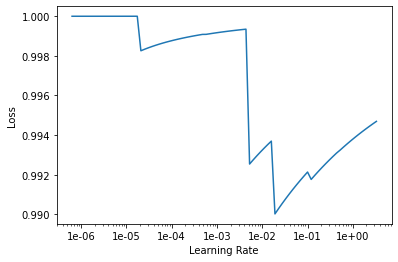

In [14]:
model = UNet3D(in_channels=1, out_channels=1)
learner = faiv.Learner(idb, model, loss_func=DiceLoss(), metrics=[MeanIoU()])
learner.lr_find()
learner.recorder.plot()

In [ ]:
lr = 1e-2
learner.fit_one_cycle(4, slice(lr), pct_start=0.8)